SYNTHETIC NET ANALYSIS

This notebook is used to divide in a specific number of REV the synthetic cubic network given as input, to compute the upscaled parameters and to solve the final coupled problem.

In [1]:
import time
from scipy.sparse import *
from dolfin import *
from block import *
from xii import *
import numpy as np
import matplotlib.pyplot as plt
import auxiliary_functions as aux
from scipy.sparse.linalg import *
from petsc4py import PETSc


/home/fra/miniconda3/envs/tesi2/lib/python3.11/site-packages/block/__init__.py:15: UserWarning: The cbc.block repository has moved to https://github.com/blocknics/cbc.block
  warnings.warn('The cbc.block repository has moved to https://github.com/blocknics/cbc.block', UserWarning)


Missing HsMG for fract norm computing


Mesh import

In [2]:
meshQ = Mesh()

mesh_name='888_mesh/888_marked_mesh.xdmf'
markers_name="888_mesh/888_markers.xdmf"
     
with XDMFFile(mesh_name) as infile:

     infile.read(meshQ)


C_markers = MeshFunction('size_t', meshQ , 0)
xdmf_file = XDMFFile(markers_name)  

xdmf_file.read(C_markers)
xdmf_file.close()

REV division process and computation of the Upscaled Parameters

In [3]:
n_div_x=2
n_div_y=2
n_div_z=2
p_in =7000
p_out=5000
min_val = 5  # Minimum value
max_val = 12 

radii=aux.generate_radom_raddii(meshQ,min_val,max_val)

#print(radii)
radii_not_scaled=radii*1e-6
dir_results = '/path/to/desktop/SYNTHETIC_NET'

K_x,K_y,K_z,C,mu_bl_up = aux.REV_division('CapillaryMesh',dir_results,meshQ,radii_not_scaled, C_markers,n_div_x,n_div_y,n_div_z,p_in,p_out,plot_mesh_flag=False, M_plot_flag=False,lap_plot_flag=False)


-------------------- MESH INFO --------------------
Coordinates: (5556, 3)
Edges: (6254, 2)
Radii: (6254,)
Labels: (5556,)
Interior Points: (5226,)
Inlet Points: (165,)
Outlet Points: (165,)

Total REV number: 8
451
783
515
826
708
819
698
756
-------------------- COMPUTING INTERSECTIONS --------------------


Coordinates with intersections: (5868, 3)
Edges with intersections: (6566, 2)
Labels with intersections: (5868,)
Radii with intersections: (6566,)

... COMPUTING K VALUES  ...

------------------------------------------------- DIRECTION: 1  -------------------------------------------------
-------------------------------------------------------------------------
REV = 1
(519, 2)
(519,)
-------------------- SUBMESH INFO --------------------
Coordinates: (408, 3)
Edges: (429, 2)
Labels: (408,)
Inlet points submesh: 21
Outlet points submesh: 35
Number of vertices: 408
Number of cells: 429
1 x
Solving linear variational problem.
-7.844961885219635e-15
-1.1989571104790168e-14
1.3580281734539379e-06
-------------------------------------------------------------------------
REV = 2
(909, 2)
(909,)
-------------------- SUBMESH INFO --------------------
Coordinates: (821, 3)
Edges: (881, 2)
Labels: (821,)
Inlet points submesh: 46
Outlet points submesh: 50
Number of vertices: 821
Number of cells:

In [4]:
#RHS TERM
formatted_vector = ['{:.2e}'.format(value) for value in C]
float_vector = [float(value) for value in formatted_vector]
print(float_vector)


[1.36e-06, 2.47e-06, 1.88e-06, 2.63e-06, 2.61e-06, 2.67e-06, 2.32e-06, 2.34e-06]


In [5]:
#UPSCALED PERMEABILITY TENSOR
formatted_vector = ['{:.2e}'.format(value) for value in K_x]
float_vector = [float(value) for value in formatted_vector]
print(float_vector)
formatted_vector = ['{:.2e}'.format(value) for value in K_y]
float_vector = [float(value) for value in formatted_vector]
print(float_vector)
formatted_vector = ['{:.2e}'.format(value) for value in K_z]
float_vector = [float(value) for value in formatted_vector]
print(float_vector)

[7.84e-15, 1.23e-14, 1.02e-14, 2.73e-14, 1.96e-14, 1.23e-14, 8.03e-15, 1.26e-14]
[4.47e-15, 2.34e-14, 1.84e-14, 1.75e-14, 1.74e-14, 2.4e-14, 2.06e-14, 1.36e-14]
[1.41e-14, 2.43e-14, 1.05e-14, 2.37e-14, 1.81e-14, 1.2e-14, 2.33e-14, 1.35e-14]


In [6]:
#UPSCALED BLOOD VISCOSITY
formatted_vector = ['{:.2e}'.format(value) for value in mu_bl_up]
float_vector = [float(value) for value in formatted_vector]
print(float_vector)


[0.00397, 0.00385, 0.00388, 0.00392, 0.00388, 0.00391, 0.00391, 0.00387]


Functions used to create the mesh and to build the problem

In [7]:
def get_mesh(n, coupling_radius,n_div_x,n_div_y,n_div_z):
     ''' Function that creates the cubic capillary and tissue meshes with respective boundary tags.
          INPUT:
               n : parameter that determines the size of the boxmesh.
               coupling_radius : parameter to reduce the mesh size at the boundary.
               n_div_x : number of division in the x direction.
               n_div_y : number of division in the y direction.
               n_div_z : number of division in the z direction.

          OUTPUT:
               meshV : cubic mesh of the region.
               Q_markers : markers for the capillary boundary points.
               V_markers : markers fot the tissue boundary points.
               ds : measure for the tissure boundary points.


     '''

     #--------------------MESHES-------------------------

     #3D mesh Tissue mesh
     inf_point = Point(-1 - 1*coupling_radius, -1 - 1*coupling_radius, -1 - 1*coupling_radius)
     max_point = Point(1 + 1*coupling_radius, 1 + 1*coupling_radius, 1 + 1*coupling_radius)
     meshV = BoxMesh(inf_point, max_point, n, n, n)
     coord_V=meshV.coordinates()

     def boundtissue(x,on_boundary):
          return on_boundary and( (x[1]<-1+DOLFIN_EPS) or (x[0]<-1+DOLFIN_EPS) or (x[2]<-1+DOLFIN_EPS) or (x[1]>1-DOLFIN_EPS) or (x[0]>1-DOLFIN_EPS) or (x[2]>1-DOLFIN_EPS))
     
     class Inflow(SubDomain):
          def inside(self,x, on_boundary): 
               return boundtissue(x, on_boundary)
          
     sub_domains = MeshFunction('size_t', meshV, meshV.topology().dim()-1)
     sub_domains.set_all(0)
     inflow_domain = Inflow()
     inflow_domain.mark(sub_domains, 1)
     V_markers = MeshFunction('size_t', meshV, 0)
     ds = Measure('ds', domain=meshV, subdomain_data=sub_domains)
     tol=1e-5
     labels_V=555*np.ones(np.shape(coord_V)[0],)

     indx=np.where(np.abs(coord_V[:,0]-np.min(coord_V[:,0]))<=tol)[0]
     labels_V[indx]=111

     indx=np.where(np.abs(coord_V[:,0]-np.max(coord_V[:,0]))<=tol)[0]
     labels_V[indx]=111

     indx=np.where(np.abs(coord_V[:,1]-np.max(coord_V[:,1]))<=tol)[0]
     labels_V[indx]=111

     indx=np.where(np.abs(coord_V[:,2]-np.max(coord_V[:,2]))<=tol)[0]
     labels_V[indx]=111

     indx=np.where(np.abs(coord_V[:,1]-np.min(coord_V[:,1]))<=tol)[0]
     labels_V[indx]=111

     indx=np.where(np.abs(coord_V[:,2]-np.min(coord_V[:,2]))<=tol)[0]
     labels_V[indx]=111
     V_markers.array()[:]=labels_V
     file = XDMFFile(f"{dir_results}/FINAL_RESULTS/MARKERS/V_markers.xdmf")
     file.write(V_markers)

     REV_labels_t=aux.compute_REV_labels(meshV,n_div_x,n_div_y,n_div_z)

     REV_markers_t = MeshFunction('size_t', meshV, 0)


     #Per ogni punto della mesh del tessuto ho i tag da 1 a 8 che mi indicano a quale REV appartiene
     REV_markers_t.array()[:]=REV_labels_t
     #print(REV_labels_t)
     file = XDMFFile(f"{dir_results}/FINAL_RESULTS/MARKERS/REV_markers.xdmf")
     file.write(REV_markers_t)

     #--------------------------------------------------

     #Capillary mesh

     tol=1e-5
     labels_Q=555*np.ones(np.shape(coord_V)[0],)

     indx=np.where(np.abs(coord_V[:,0]-np.min(coord_V[:,0]))<=tol)[0]
     labels_Q[indx]=111

     indx=np.where(np.abs(coord_V[:,0]-np.max(coord_V[:,0]))<=tol)[0]
     labels_Q[indx]=999

     indx=np.where(np.abs(coord_V[:,1]-np.min(coord_V[:,1]))<=tol)[0]
     labels_Q[indx]=111

     indx=np.where(np.abs(coord_V[:,1]-np.max(coord_V[:,1]))<=tol)[0]
     labels_Q[indx]=999

     indx=np.where(np.abs(coord_V[:,2]-np.min(coord_V[:,2]))<=tol)[0]
     labels_Q[indx]=111
     
     indx=np.where(np.abs(coord_V[:,2]-np.max(coord_V[:,2]))<=tol)[0]
     labels_Q[indx]=999

     print(type(labels_Q))

     Q_markers = MeshFunction('size_t', meshV, 0)

     Q_markers.array()[:]=labels_Q
     file = XDMFFile(f"{dir_results}/FINAL_RESULTS/MARKERS/Q_markers.xdmf")
     file.write(Q_markers)
     
     coord_V=meshV.coordinates()

     fig = plt.figure(figsize=(8, 6))
     ax = fig.add_subplot(111, projection='3d')
     scatter_plot=ax.scatter(coord_V[:,0],coord_V[:,1],coord_V[:,2],c=REV_markers_t.array())
     cbar = fig.colorbar(scatter_plot, ax=ax, pad=0.1)
     plt.title('REV division markers')


     fig = plt.figure(figsize=(8, 6))
     ax = fig.add_subplot(111, projection='3d')
     scatter_plot=ax.scatter(coord_V[:,0],coord_V[:,1],coord_V[:,2],c=V_markers.array())
     cbar = fig.colorbar(scatter_plot, ax=ax, pad=0.1)
     plt.title('Boundary markers for the tissue mesh')

     

     fig = plt.figure(figsize=(8, 6))
     ax = fig.add_subplot(111, projection='3d')
     scatter_plot=ax.scatter(coord_V[:,0],coord_V[:,1],coord_V[:,2],c=Q_markers.array())
     cbar = fig.colorbar(scatter_plot, ax=ax, pad=0.1)
     plt.title('Boundary markers for the capillary mesh')




     return meshV, Q_markers, V_markers, REV_markers_t, ds

def get_system(meshV, K_x, K_y, K_z, C, mu_bl_up, beta_value, p0_value,ds):
      ''' Function that assemble the matrices to solve the problem
          INPUT:
               meshV : mesh of the cubic geometry.
               K_x :  x components of the permeability tensor, one for each REV.
               K_y :  y components of the permeability tensor, one for each REV.
               K_z :  z components of the permeability tensor, one for each REV.
               C : RHS terms, one for each REV.
               mu_bl_up : upscaled blood viscosity terms, one for each REV.
               beta_value :  Neumann parameter fot the tissue.
               p0_value : initial reference pressure value for the tissue.
               ds : measure for the tissue.

            OUTPUT:
                AD : stiffness matrix.
                M : mass matrix.
                b : RHS term
                W : space of the solutions.
                T : total matrix.
      
      '''
      #"""A, b, bcs"""


      # Spaces
      nRev=8
      #Q = FunctionSpace(meshQ, 'CG', 1)
      V = FunctionSpace(meshV, 'CG', 1)

      W = (V, V)

      pcap, pt = map(TrialFunction, W)
      qcap, qt= map(TestFunction, W)

      #----------------------------------------------------------
     
      #Parameters
 

      rho_bl = Constant(1030) #kg/m^3
      rho_int = Constant(1000) #kg/m^3
      mu_int= Constant(1.3*1e-3) #Pa * s
      k_t = Constant(1e-18) #m^2
      K_T=Constant(rho_int*k_t/mu_int)

      pi_p = Constant(3300)
      pi_int = Constant(666)
      p0 = Constant(p0_value)

      
      beta = Constant(beta_value)
    
      
      #-------------------------------------------------------------------

      class K(UserExpression):

        def __init__(self, mesh, REV_division, nRev, K_x, K_y, K_z, mu_bl_up,**kwargs):
                super().__init__()
                self.REV_division = REV_division
                self.nRev=nRev
                self.K_x = K_x
                self.K_y = K_y
                self.K_z = K_z
                self.mu_bl_up_x = mu_bl_up
                self.mu_bl_up_y = mu_bl_up
                self.mu_bl_up_z = mu_bl_up
                self.mesh=mesh

        def value_shape(self):
            return (3, 3)

        def eval(self, values, x):
            "Set value[0] to value at point x"
            tol = 1E-14
            for REV in range(self.nRev):

                xmin=self.REV_division[REV+1]['xmin']
                xmax=self.REV_division[REV+1]['xmax']
                ymin=self.REV_division[REV+1]['ymin']
                ymax=self.REV_division[REV+1]['ymax']
                zmin=self.REV_division[REV+1]['zmin']
                zmax=self.REV_division[REV+1]['zmax']
            
                if (((x[0]-xmin)>=-tol) and ((x[0]-xmax)<=tol) and ((x[1]-ymin)>=-tol) and ((x[1]-ymax)<=tol) and ((x[2]-zmin)>=-tol) and ((x[2]-zmax)<=tol)):
                    values[0] = self.K_x[REV] / self.mu_bl_up_x[REV]
                    values[1] = 0
                    values[2] = 0
                    values[3] = 0
                    values[4] = self.K_y[REV] / self.mu_bl_up_y[REV]
                    values[5] = 0
                    values[6] = 0
                    values[7] = 0
                    values[8] = self.K_z[REV] / self.mu_bl_up_z[REV]
                    break

      REV_division=aux.create_dictionary(meshV,2,2,2)
      kappa = K(meshV, REV_division,nRev, K_x,K_y,K_z,mu_bl_up,degree=2)
    
      a00= rho_bl * inner(kappa * grad(pcap), grad(qcap)) * dx 
      
      a11 = K_T * inner(grad(pt), grad(qt)) * dx + beta * inner(pt, qt)* ds(1)

      AD = block_assemble([[a00,0], [0,a11]])

      class Cval(UserExpression):
        def __init__(self,mesh, REV_division,nRev, C, **kwargs):
            super().__init__()
            self.REV_division = REV_division
            self.nRev=nRev
            self.C = C
            self.mesh = mesh

        def eval(self, values, x):
            "Set value[0] to value at point x"
            tol = 1E-14
            for REV in range(self.nRev):

                xmin=self.REV_division[REV+1]['xmin']
                xmax=self.REV_division[REV+1]['xmax']
                ymin=self.REV_division[REV+1]['ymin']
                ymax=self.REV_division[REV+1]['ymax']
                zmin=self.REV_division[REV+1]['zmin']
                zmax=self.REV_division[REV+1]['zmax']
            
                if (((x[0]-xmin)>=-tol) and ((x[0]-xmax)<=tol) and ((x[1]-ymin)>=-tol) and ((x[1]-ymax)<=tol) and ((x[2]-zmin)>=-tol) and ((x[2]-zmax)<=tol)):
                    values[0] = self.C[REV]
                    break

        def value_shape(self):
            return ()


      #C_val=Constant(C[0])

      CC = Cval(meshV,REV_division,nRev,C, degree=2)

      L0 = CC * inner((pi_p - pi_int) , qcap) * dx
      L1 = - CC *  inner((pi_p - pi_int) ,qt) * dx + beta * inner(p0, qt) * ds(1)



      b = block_assemble([L0,L1])


      m00 = CC * inner(pcap, qcap) * dx
      m01 = - CC *  inner(pt, qcap) * dx
      m10 = - CC *  inner(pcap, qt) * dx
      m11 = CC * inner(pt, qt) * dx


      M00=assemble(m00)
      M01=assemble(m01)
      M10=assemble(m10)
      M11=assemble(m11)
    
      M=block_mat([[M00, M01],[M10,M11]])

      T=block_assemble([[a00+m00, m01],[m10,a11+m11]])

      return AD, M, b, W, T

      #---------------------------------------------------------------------------------------
      #---------------------------------------------------------------------------------------


Main

Total REV: 8
<class 'numpy.ndarray'>

------------------ System setup and assembly time:  20.903416395187378 



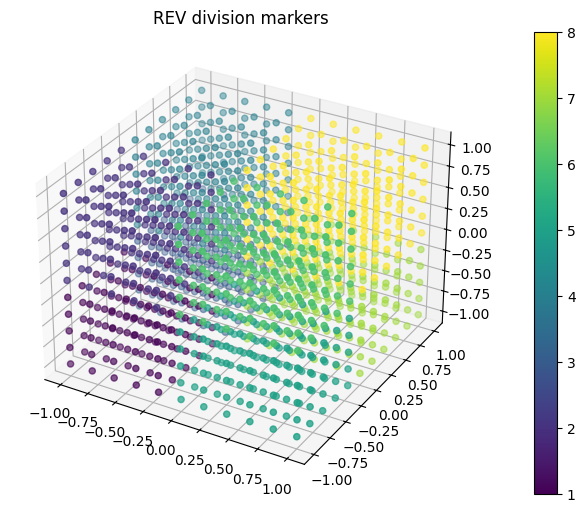

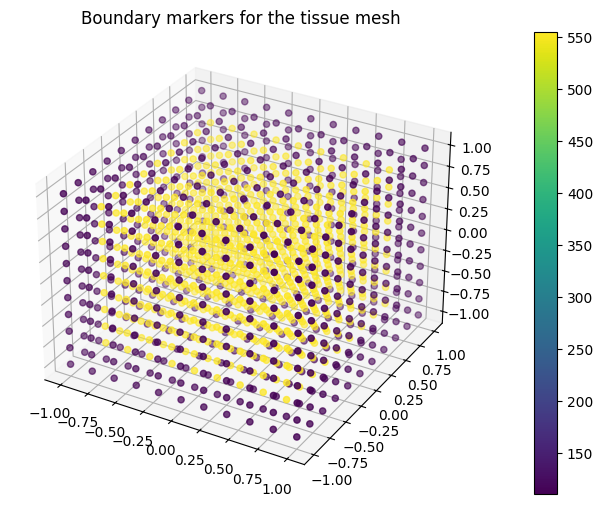

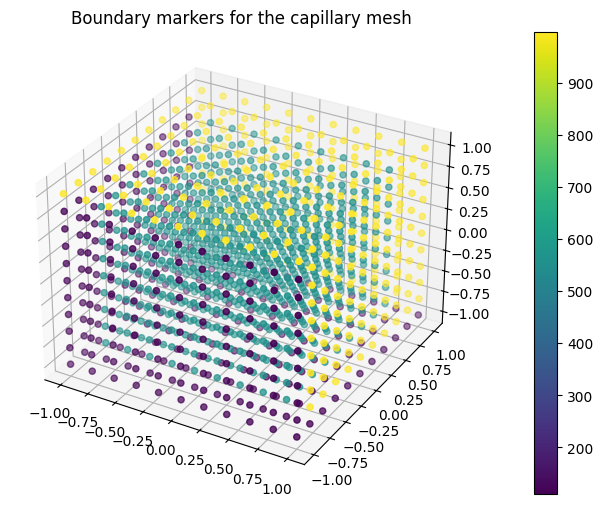

In [8]:
#Mesh parameters
max_radius = 0
nn = 10


#--------------------------------------------------------------------

# # Get discrete system
start_time = time.time()
tag_in=111
tag_out=999
beta_value = 1e-3 # Neumann for tissue
p0_value = 7000

nREV=8


# meshV, Q_markers, V_markers, REV_markers_t = get_mesh(nn, max_radius,n_div_x,n_div_y,n_div_z)
meshV, Q_markers, V_markers, REV_markers_t ,ds = get_mesh(nn, max_radius,n_div_x,n_div_y,n_div_z)


AD, M, b, W, T = get_system(meshV, K_x, K_y, K_z, C, mu_bl_up, beta_value, p0_value,ds)


print("\n------------------ System setup and assembly time: ", time.time() - start_time, "\n")





Application of the Dirichlet boundary condition for the capillary

In [9]:
V = FunctionSpace(meshV, 'CG', 1)

bc_in = [DirichletBC(V, 7000, "on_boundary&&( (x[1]<-1+DOLFIN_EPS) || (x[0]<-1+DOLFIN_EPS) || (x[2]<-1+DOLFIN_EPS) )"),DirichletBC(V, 5000, "on_boundary&&( (x[1]>1-DOLFIN_EPS) || (x[0]>1-DOLFIN_EPS) || (x[2]>1-DOLFIN_EPS))")]

bcs = block_bc([bc_in, []], True)
bcs.apply(T).apply(b)


[[<dolfin.fem.dirichletbc.DirichletBC at 0x7f9477fe3ad0>,
 []]

Solving the Linear System

KSP Object: 1 MPI process
  type: gmres
    restart=30, using Classical (unmodified) Gram-Schmidt Orthogonalization with no iterative refinement
    happy breakdown tolerance 1e-30
  maximum iterations=10000, initial guess is zero
  tolerances:  relative=1e-15, absolute=1e-50, divergence=10000.
  right preconditioning
  using DEFAULT norm type for convergence test
PC Object: 1 MPI process
  type: ilu
  PC has not been set up so information may be incomplete
    out-of-place factorization
    0 levels of fill
    tolerance for zero pivot 2.22045e-14
    matrix ordering: natural
    matrix solver type: petsc
    matrix not yet factored; no additional information available
  linear system matrix = precond matrix:
  Mat Object: 1 MPI process
    type: seqaij
    rows=2662, cols=2662
    total: nonzeros=68764, allocated nonzeros=68764
    total number of mallocs used during MatSetValues calls=0
      not using I-node routines
iterations =  9
residual =  1.29e-10
converge reason =  2
residua

Text(0.5, 0.92, 'Tissue Pressure (Pa)')

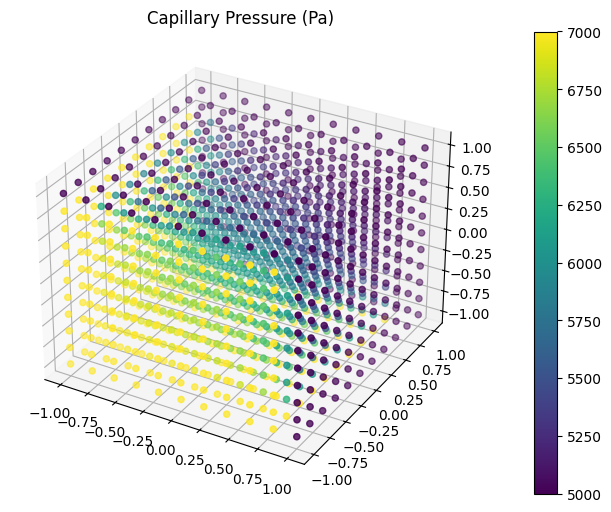

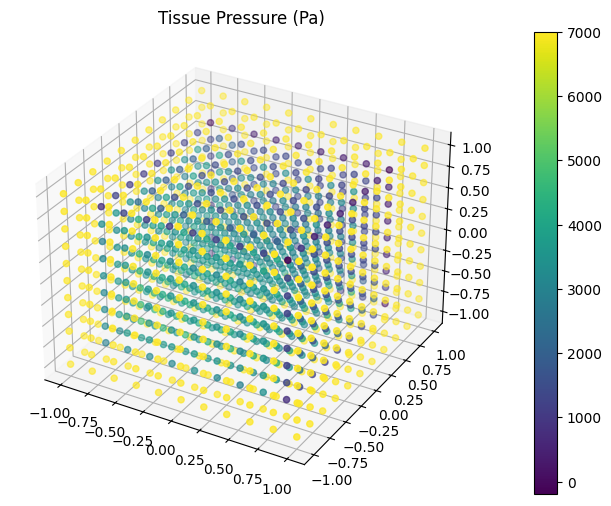

In [10]:

b_PET = ii_convert(b)
shape = b_PET.size()  
A_PET = ii_convert(T).mat()
b_PET = b_PET.vec()
u     = np.zeros((shape))
tol   = 1e-15
u_PET = PETSc.Vec().createWithArray(u)

# Create a PETSc Krylov solver
solver = PETSc.KSP().create()
solver.setOperators(A_PET)
solver.setType(PETSc.KSP.Type.GMRES)  # <--Choose the solver type
solver.setFromOptions()  # <--Allow setting options from the command line or a file
solver.setTolerances(rtol=tol)
solver.setPCSide(1)
solver.view()

# Set preconditioner
pc = solver.getPC()
pc.setType(PETSc.PC.Type.HYPRE)
#pc.setHYPREType("boomeramg")  # Set to use AMG
#pc.setType(PETSc.PC.Type.ILU)
#c.setType(PETSc.PC.Type.NONE)
#pc.setType(PETSc.PC.Type.JACOBI)


solver.solve(b_PET, u_PET)

# print
print ('iterations = ',               solver.getIterationNumber())
print ('residual = ', '{:.2e}'.format(solver.getResidualNorm()))#  %.2E
print ('converge reason = ',          solver.getConvergedReason())
print ('residuals at each iter = ',   solver.getConvergenceHistory())
#print ('precond type', pc.getType())
# Print solver information
num_iter = solver.getIterationNumber()
print(f"Number of iterations: {num_iter}")

print("\n------------------  System solved time: ", time.time() - start_time, "\n")


#Saving the results
Q = FunctionSpace(meshV, 'CG', 1)
dimQ= Q.dim()

pcap_pet_Q = u_PET[:dimQ]
pt_pet_Q = u_PET[dimQ:]

print(np.shape(pcap_pet_Q))
print(np.shape(pt_pet_Q))


p_cap=Function(Q)
p_t=Function(Q)


p_cap.vector()[:]=pcap_pet_Q
p_t.vector()[:]=pt_pet_Q
coord_V=meshV.coordinates()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter_plot=ax.scatter(coord_V[:,0],coord_V[:,1],coord_V[:,2],c=p_cap.compute_vertex_values(meshV))
cbar = fig.colorbar(scatter_plot, ax=ax, pad=0.1)
plt.title('Capillary Pressure (Pa)')

coord_V=meshV.coordinates()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter_plot=ax.scatter(coord_V[:,0],coord_V[:,1],coord_V[:,2],c=p_t.compute_vertex_values(meshV))
cbar = fig.colorbar(scatter_plot, ax=ax, pad=0.1)
plt.title('Tissue Pressure (Pa)')


In [11]:
#Saving

File(f'{dir_results}/FINAL_RESULTS/MARKERS/meshV.pvd') << meshV
File(f'{dir_results}/FINAL_RESULTS/PETSC/pcap_test_case.pvd') << p_cap
File(f'{dir_results}/FINAL_RESULTS/PETSC/pt_test_case.pvd') << p_t